In [1]:
from collections import Counter
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from bar_model import BarModel
from efbp import run_simulation
from util import detect_cycle

In [2]:
rng = np.random.default_rng(24)
n = 150
agents = 100
x_min = -1
x_max = 1

In [69]:
def find_subsequence(seq, subseq):
    target = np.dot(subseq, subseq)
    candidates = np.where(np.correlate(seq,
                                       subseq, mode='valid') == target)[0]
    # some of the candidates entries may be false positives, double check
    check = candidates[:, np.newaxis] + np.arange(len(subseq))
    mask = np.all((np.take(seq, check) == subseq), axis=-1)
    return candidates[mask]


def find_case_network(strategies):
    start = rng.choice(101, size=4)

    edges = []

    hist_sim, _, _ = run_simulation(
        agents = agents,
        threshold = 60,
        strategies = strategies,
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 2,
        # number of rounds to run the simulation
        n_iter = n,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # random seed for numpy
        seed=rng.choice(10000)
    )

    cases_sim = np.array([
        BarModel(hist_sim[i:i+4], strategies, x_min, x_max).case
        for i in range(n-4)
    ])

    cycle_length = detect_cycle(cases_sim, 2)
    cycle = cases_sim[-cycle_length:]

    # don't keep iterating through cycle
    # only cover it once
    end = find_subsequence(cases_sim, cycle)[1]

    for i in range(end):
        case = cases_sim[i]
        next_case = cases_sim[i+1]
        edges.append(((case, next_case)))
        
    return Counter(edges)

In [70]:
find_case_network(2)

Counter({(10, 9): 4,
         (9, 2): 1,
         (2, 10): 1,
         (10, 15): 4,
         (15, 9): 4,
         (9, 14): 3,
         (14, 5): 1,
         (5, 9): 1,
         (9, 3): 4,
         (3, 10): 4,
         (9, 16): 1,
         (16, 6): 1,
         (6, 9): 2,
         (14, 10): 2,
         (9, 10): 2,
         (10, 6): 1})

In [98]:
strategies = 2
times = 1000

cases = find_case_network(strategies)

for _ in range(times):
    cases.update(find_case_network(strategies))

In [113]:
cases.most_common(15)

[((3, 10), 3628),
 ((9, 3), 3624),
 ((10, 9), 3345),
 ((9, 14), 2691),
 ((10, 15), 2575),
 ((15, 9), 2306),
 ((14, 10), 1856),
 ((6, 9), 1754),
 ((9, 16), 993),
 ((16, 6), 923),
 ((2, 10), 895),
 ((5, 9), 782),
 ((10, 6), 776),
 ((9, 10), 755),
 ((14, 5), 743)]

In [114]:
G = nx.DiGraph()

for edge in cases.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)

In [115]:
G.nodes

NodeView((3, 10, 15, 9, 16, 6, 14, 1, 13, 2, 5, 4, 19, 12))

In [116]:
[G.degree(x) * 20 for x in G.nodes]

[60, 200, 100, 320, 120, 80, 120, 60, 100, 120, 60, 60, 40, 40]

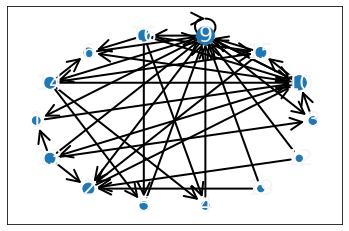

In [103]:
pos = nx.circular_layout(G)

nodesize = [G.degree(x) * 20 for x in G.nodes]

nodes = nx.draw_networkx_nodes(G, pos, node_size=nodesize)
edges = nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="->",
    arrowsize=30,
    width=2,
)

labels = {node: node for node in G.nodes}
_ = nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="whitesmoke")


In [117]:
for c in nx.strongly_connected_components(G):
    print(c)

{1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 16}
{19}
{12}


In [119]:
for case in cases:
    if case[0] == 19:
        print(case)

(19, 2)
(19, 9)


In [120]:
len(G.nodes)

14

## Try with more strategies

In [59]:
strategies = 3
times = 1000

cases = find_case_network(strategies)

for _ in range(times):
    cases.update(find_case_network(strategies))

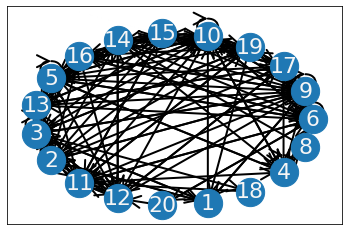

In [60]:
G = nx.DiGraph()

for edge in cases.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
pos = nx.circular_layout(G)

nodes = nx.draw_networkx_nodes(G, pos, node_size=800)
edges = nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="->",
    arrowsize=30,
    width=2,
)

labels = {node: node for node in G.nodes}
_ = nx.draw_networkx_labels(G, pos, labels, font_size=22, font_color="whitesmoke")

In [61]:
for c in nx.strongly_connected_components(G):
    print(c)

{1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}


# Only consider limit cycles

In [150]:
n = 150

def find_case_network(strategies):
    start = rng.choice(101, size=4)

    hist_sim, _, _ = run_simulation(
        agents = agents,
        threshold = 60,
        strategies = strategies,
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 2,
        # number of rounds to run the simulation
        n_iter = n,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # random seed for numpy
        seed=rng.choice(10000)
    )

    cases_sim = np.array([
        BarModel(hist_sim[i:i+4], strategies, x_min, x_max).case
        for i in range(n-4)
    ])

    cycle_length = detect_cycle(cases_sim, 2)
    cycle = cases_sim[-cycle_length:]

    # don't keep iterating through cycle
    # only cover it once
    end = find_subsequence(cases_sim, cycle)[0]
    
    # consider cases before the beginning of the cycle
    edges = []
    
    for i in range(cycle_length):
        case = cycle[i]
        next_case = cycle[(i+1) % cycle_length]
        edges.append(((case, next_case)))
    pre_counts = Counter(edges)
    

    # cases in the cycle
    edges = []
    for i in range(end):
        case = cases_sim[i]
        next_case = cases_sim[(i+1)]
        edges.append(((case, next_case)))
        
    cycle_counts = Counter(edges)
        
    return pre_counts, cycle_counts

In [151]:
strategies = 2
times = 1000

pre_cnts, cycle_cnts = find_case_network(strategies)

for t in range(times):
    p, c = find_case_network(strategies)
    pre_cnts.update(p)
    cycle_cnts.update(c)

In [152]:
G = nx.DiGraph()

for edge in pre_cnts.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
for c in nx.strongly_connected_components(G):
    print(c)

{1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 16}


Missing cases 7,8, 11, 12, 17, 18, 19,20

In [153]:
G = nx.DiGraph()

for edge in cycle_cnts.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
for c in nx.strongly_connected_components(G):
    print(c)

{1, 2, 3, 4, 5, 6, 9, 10, 13, 14, 15, 16}
{19}


NOTE: names of arrays are switched.  pre_cnts is the one that has the cycles.

Okay interesting...  It seems like some cases don't get generated by the simulation ever and they aren't the ones I would have picked out.  7 and 8 are the obvious ones, where there are 3 in a row of the same choice.  The remaining cases are all ones with 

In [154]:
strategies = 3
times = 1000

pre_cnts, cycle_cnts = find_case_network(strategies)

for t in range(times):
    p, c = find_case_network(strategies)
    pre_cnts.update(p)
    cycle_cnts.update(c)
    
    
G = nx.DiGraph()

for edge in pre_cnts.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
for c in nx.strongly_connected_components(G):
    print(c)

{1, 2, 3, 5, 6, 9, 10, 13, 14, 15, 16}


In [155]:
G = nx.DiGraph()

for edge in cycle_cnts.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
for c in nx.strongly_connected_components(G):
    print(c)

{2, 3, 5, 6, 9, 10, 13, 14, 15, 16, 19}
{12}
{11}
{17}


In [156]:
strategies = 10
times = 1000

pre_cnts, cycle_cnts = find_case_network(strategies)

for t in range(times):
    p, c = find_case_network(strategies)
    pre_cnts.update(p)
    cycle_cnts.update(c)
    
    
G = nx.DiGraph()

for edge in pre_cnts.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
for c in nx.strongly_connected_components(G):
    print(c)

{2, 10, 19, 15}
{4, 5, 9, 14, 17}


In [157]:
G = nx.DiGraph()

for edge in cycle_cnts.items():
    (u, v), w = edge
    G.add_edge(u, v, weight=w)
    
for c in nx.strongly_connected_components(G):
    print(c)

{1, 2, 10, 12, 15, 19}
{4, 5, 9, 14, 17}
{11}
{16}


In [203]:
n = 30

def test_no_negative_a_optimal(strategies):
    start = rng.choice(101, size=4)

    hist_sim, _, _ = run_simulation(
        agents = agents,
        threshold = 60,
        strategies = strategies,
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 2,
        # number of rounds to run the simulation
        n_iter = n,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # random seed for numpy
        seed=rng.choice(10000)
    )

    for i in range(1, n-4):
        m = BarModel(hist_sim[i:i+4], strategies, x_min, x_max)
        if m.case < 9:
            continue
            
        if m.opt_a < 0:
            print(start)
            print(hist_sim)
            print(i)
            print(m.case)
            return start, hist_sim, i
        
    return None
        

for _ in range(500):
    r = test_no_negative_a_optimal(2)
    if r:
        print("found a negative optimal a value:")

In [204]:
for _ in range(500):
    r = test_no_negative_a_optimal(3)
    if r:
        print("found a negative optimal a value:")

[39 53 40 59]
[100  11   5 100  38  17 100  32   5 100  38   9 100  35   4 100  38   7
 100  35   4 100  38   7 100  35   4 100  38   7]
4
19
found a negative optimal a value:
[47 23 38 49]
[100  40  19 100  30   3 100  40  13 100  33   4 100  40  11 100  37   7
 100  38   7 100  38   7 100  38   7 100  38   7]
1
19
found a negative optimal a value:


In [205]:
for _ in range(500):
    r = test_no_negative_a_optimal(10)
    if r:
        print("found a negative optimal a value:")

[82 49 49 53]
[  4   0 100   9   2 100   8   2 100   8   2 100   8   2 100   8   2 100
   8   2 100   8   2 100   8   2 100   8   2 100]
3
19
found a negative optimal a value:
[19 34 27 27]
[100   7   0 100   8   1 100   7   0 100   8   1 100   7   0 100   8   1
 100   7   0 100   8   1 100   7   0 100   8   1]
4
19
found a negative optimal a value:
[82 58  7  6]
[ 99   2   0 100   7   1 100   6   0 100   7   1 100   6   0 100   7   1
 100   6   0 100   7   1 100   6   0 100   7   1]
4
19
found a negative optimal a value:
[60 48 65 52]
[  0  77 100   0  98 100   0  98 100   0  98 100   0  98 100   0  98 100
   0  98 100   0  98 100   0  98 100   0  98 100]
1
17
found a negative optimal a value:
[ 2  0 39 66]
[  0  84 100   0  94 100   0  94 100   0  94 100   0  94 100   0  94 100
   0  94 100   0  94 100   0  94 100   0  94 100]
1
17
found a negative optimal a value:
[10 17 31 59]
[  5   0 100   8   2 100   7   2 100   7   2 100   7   2 100   7   2 100
   7   2 100   7   2 100   7   2 

In [211]:
n = 80

def test_no_negative_cycle_a_optimal(strategies):
    start = rng.choice(101, size=4)

    hist_sim, _, _ = run_simulation(
        agents = agents,
        threshold = 60,
        strategies = strategies,
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 2,
        # number of rounds to run the simulation
        n_iter = n,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # random seed for numpy
        seed=rng.choice(10000)
    )
    
    cycle_length = detect_cycle(hist_sim, 2)
    
    if cycle_length is None:
        return None, None, None
    cycle = hist_sim[-cycle_length:]

    for i in range(cycle_length-4):
        m = BarModel(cycle[i:i+4], strategies, x_min, x_max)
        if m.case < 9:
            continue
            
        if m.opt_a < 0:
            print(start)
            print(hist_sim)
            print(i)
            print(m.case)
            return start, hist_sim, i
        
    return None
        

for _ in range(500):
    r = test_no_negative_cycle_a_optimal(2)
    if r:
        print("found a negative optimal a value:")

In [212]:
for _ in range(500):
    r = test_no_negative_cycle_a_optimal(3)
    if r:
        print("found a negative optimal a value:")

In [213]:
for _ in range(500):
    r = test_no_negative_cycle_a_optimal(10)
    if r:
        print("found a negative optimal a value:")

[31 68 10 71]
[  2   0 100  14   4 100   9   0 100  14   4 100   9   0 100  14   4 100
   9   0 100  14   4 100   9   0 100  14   4 100   9   0 100  14   4 100
   9   0 100  14   4 100   9   0 100  14   4 100   9   0 100  14   4 100
   9   0 100  14   4 100   9   0 100  14   4 100   9   0 100  14   4 100
   9   0 100  14   4 100   9   0]
1
19
found a negative optimal a value:
